In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os, random
import torch

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential

In [2]:
data_dir  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


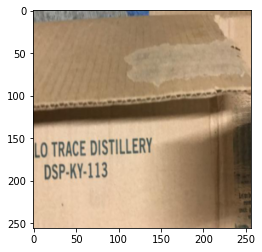

In [5]:
img, label = dataset[12]
show_sample(img, label)

In [6]:
base_path = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'

img_list = glob.glob(os.path.join(base_path, '*/*.jpg'))

print(len(img_list))

2527


In [7]:
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
split_1 = int(0.8 * len(img_list))
split_2 = int(0.9 * len(img_list))
train_data = img_list[:split_1]
dev_data = img_list[split_1:split_2]
test_data = img_list[split_2:]
print("Train Data")
print(len(train_data))
print("Dev Data")
print(len(dev_data))
print("Test Data")
print(len(test_data))

Train Data
2021
Dev Data
253
Test Data
253


In [9]:
# for i, img_path in enumerate(random.sample(img_list, 6)):
#     img = load_img(img_path)
#     img = img_to_array(img, dtype=np.uint8)

#     plt.subplot(2, 3, i+1)
#     plt.imshow(img.squeeze())

In [10]:
# from torch.utils.data.dataloader import DataLoader
# batch_size = 32

In [11]:
# train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

In [12]:
# def accuracy(outputs, labels):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# class ImageClassificationBase(nn.Module):
#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         loss = F.cross_entropy(out, labels) # Calculate loss
#         return loss
    
#     def validation_step(self, batch):
#         images, labels = batch 
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels)           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}
        
#     def validation_epoch_end(self, outputs):
#         batch_losses = [x['val_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self, epoch, result):
#         print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
#             epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
# class ResNet(ImageClassificationBase):
#     def __init__(self):
#         super().__init__()
#         # Use a pretrained model
#         self.network = models.resnet50(pretrained=True)
#         # Replace last layer
#         num_ftrs = self.network.fc.in_features
#         self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
#     def forward(self, xb):
#         return torch.sigmoid(self.network(xb))

# model = ResNet()

In [14]:
# def get_default_device():
#     """Pick GPU if available, else CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')
    
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

In [15]:
# device = get_default_device()
# device

In [16]:
# train_dl = DeviceDataLoader(train_dl, device)
# val_dl = DeviceDataLoader(val_dl, device)
# to_device(model, device)

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed=0
)


labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [18]:
# def get_default_device():
#     """Pick GPU if available, else CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')
    
# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list,tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)
# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device
        
#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl: 
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)

# device = get_default_device()
# device


In [19]:
# class Net(nn.Module):

#     def __init__(self):
#         super(Net, self).__init__()
#         # 1 input image channel, 6 output channels, 5x5 square convolution
#         # kernel
#         self.conv1 = nn.Conv2d(1, 6, 5)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension 
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         # Max pooling over a (2, 2) window
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square, you can specify with a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features


# net = Net()
# print(net)

In [20]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(64, activation='relu'),

    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        9

In [21]:
model.fit_generator(train_generator, epochs=20, validation_data=validation_generator)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
143/143 [==============================] - 217s 2s/step - loss: 1.7185 - acc: 0.2213 - val_loss: 1.5607 - val_acc: 0.3028
Epoch 2/20
143/143 [==============================] - 213s 1s/step - loss: 1.4555 - acc: 0.3956 - val_loss: 1.3728 - val_acc: 0.4064
Epoch 3/20
143/143 [==============================] - 212s 1s/step - loss: 1.3449 - acc: 0.4422 - val_loss: 1.3224 - val_acc: 0.4502
Epoch 4/20
143/143 [==============================] - 212s 1s/step - loss: 1.2629 - acc: 0.4991 - val_loss: 1.3226 - val_acc: 0.4861
Epoch 5/20
143/143 [==============================] - 212s 1s/step - loss: 1.2173 - acc: 0.5295 - val_loss: 1.2742 - val_acc: 0.4940
Epoch 6/20
143/143 [==============================] - 212s 1s/step - loss: 1.1781 - acc: 0.5418 - val_loss: 1.2220 - val_acc: 0.5578
Epoch 7/20
143/143 [==============================] - 212s 1s/step - loss: 1.0739 - acc: 0.5906 - val_loss: 1.2418 - val_acc: 0.5299
Epoch 8/20
143/143 [==============================] - 212s 1s/step - 

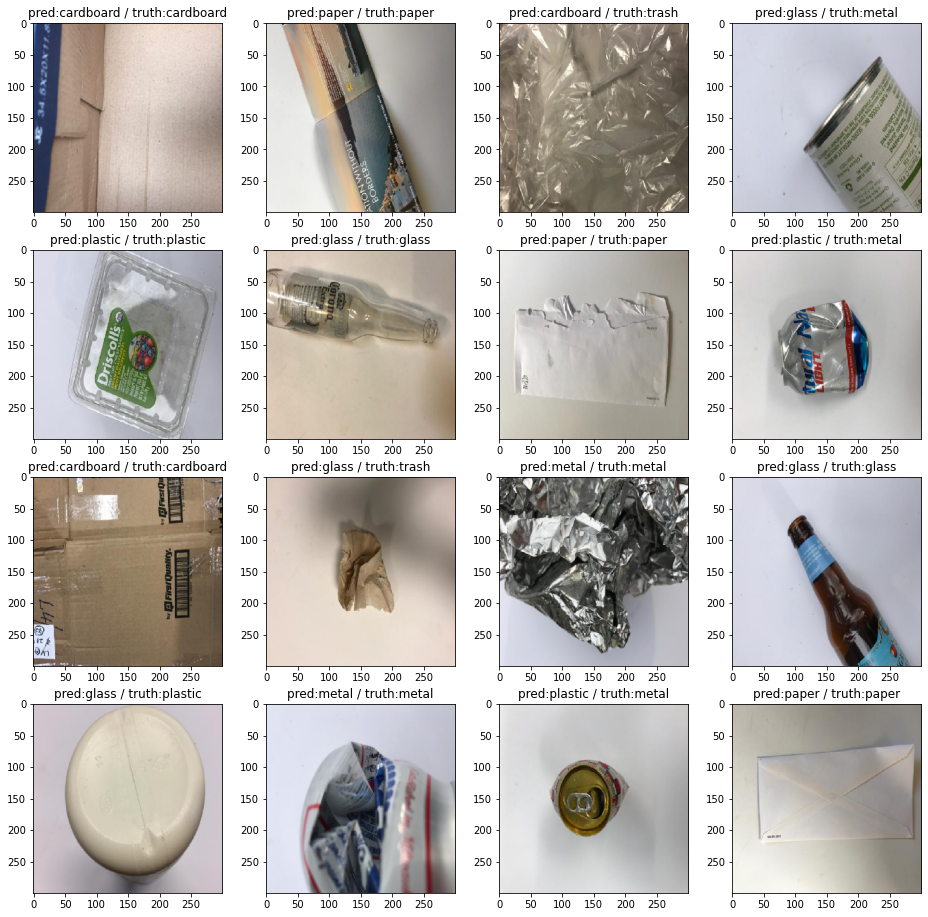

In [22]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])